<a href="https://colab.research.google.com/github/osadly/Courses/blob/main/ML/McGill%20School%20of%20Continuing%20Studies/YCBS%20258%20-%20Practical%20Machine%20Learning/Homework_M3_04OCT24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment
Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select "Runtime", then "Runtime Type". Make sure "Hardware Accelerator" has the option "GPU" selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

#TF Version & GPUs available
print('TF Version: ' + str(tf.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Access to GPU details:
!nvidia-smi

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TF Version: 2.17.0
Num GPUs Available:  1
Sat Oct  5 03:15:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |  

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


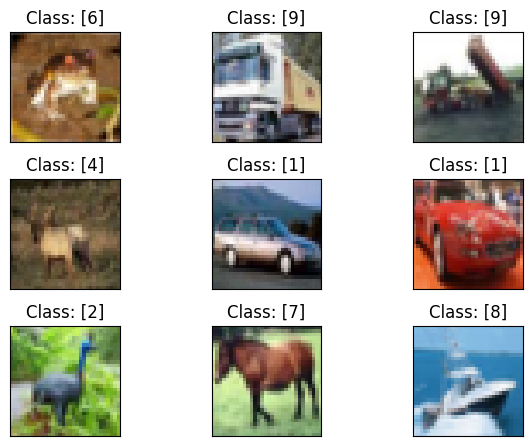

In [5]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
X_train_full.shape

(50000, 32, 32, 3)

In [7]:
y_train_full.shape

(50000, 1)

In [8]:
# Train, Validate & Test
# Split train_full into train & test
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models
import random
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

K.clear_session()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=47)

print("===============================================")
print("X_test.shape", X_test.shape)             # (10000, 32, 32, 3)
print("y_test.shape", y_test.shape)             # (10000, 1)
print("===============================================")
print("X_train.shape", X_train.shape)  # (40000, 32, 32, 3)
print("y_train.shape",y_train.shape)  # (40000, 1)
print("===============================================")
print("X_val.shape",X_val.shape)    # (10000, 32, 32, 3)
print("y_val.shape",y_val.shape)    # (10000, 1)

X_test.shape (10000, 32, 32, 3)
y_test.shape (10000, 1)
X_train.shape (40000, 32, 32, 3)
y_train.shape (40000, 1)
X_val.shape (10000, 32, 32, 3)
y_val.shape (10000, 1)


In [9]:
print(y_train[0], y_train[10], y_train[200])

[0] [1] [4]


In [10]:
# Z-score normalization
x_train_norm = np.zeros_like(X_train)
x_val_norm = np.zeros_like(X_val)
x_test_norm = np.zeros_like(X_test)

# Normalize each channel of the RGB channels
for i in range(3):
    mean = X_train[:, :, :, i].mean()
    std_dev = X_train[:, :, :, i].std()
    #print(mean,std_dev)
    x_train_norm[:, :, :, i] = (X_train[:, :, :, i] - mean) / std_dev
    x_val_norm[:, :, :, i] = (x_val_norm[:, :, :, i] - mean) / std_dev
    x_test_norm[:, :, :, i] = (X_test[:, :, :, i] - mean) / std_dev

#print(x_train_norm)
#print(x_test_norm)

In [11]:
# One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(40000, 10)
(10000, 10)
(10000, 10)


In [12]:
print(y_train_cat[0], y_train_cat[10], y_train_cat[200])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### AlexNet - Using Functional API

In [31]:
def AlexNetScaled(input_shape=(32, 32, 3), num_classes=10):
  # Calculate scaled parameters
  kernel_size = 1
  strides = 1
  num_filters = [11,36,54,54,36]

  # Input layer
  inputs = layers.Input(shape=input_shape)

  # 1st Convolutional Layer
  x = layers.Conv2D(filters=num_filters[0], kernel_size=(kernel_size, kernel_size),
                    strides=(strides, strides), padding='valid', activation='relu')(inputs)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer
  x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
  x = layers.Dropout(0.25)(x)  # Dropout after 1st pooling layer

  # 2nd Convolutional Layer
  x = layers.Conv2D(filters=num_filters[1], kernel_size=(kernel_size, kernel_size),
                    strides=(1, 1), padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
  x = layers.Dropout(0.25)(x)  # Dropout after 2nd pooling layer

  # 3rd Convolutional Layer
  x = layers.Conv2D(filters=num_filters[2], kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation='relu')(x)
  # 4th Convolutional Layer
  x = layers.Conv2D(filters=num_filters[3], kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation='relu')(x)

  # 5th Convolutional Layer
  x = layers.Conv2D(filters=num_filters[4], kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation='relu')(x)

  x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
  x = layers.Dropout(0.25)(x)  # Dropout after 3rd pooling layer

  # Flatten the network output for Fully Connected Layers
  x = layers.Flatten()(x)

  # 1st Fully Connected Layer
  x = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)
  x = layers.Dropout(0.4)(x)  # Dropout for regularization

  # 2nd Fully Connected Layer
  x = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)
  x = layers.Dropout(0.4)(x)  # Dropout for regularization

  # Output Layer (with softmax for classification)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  # Create the model
  model = models.Model(inputs=inputs, outputs=outputs)

  return model

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 11)          │              44 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 15, 15, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 15, 15, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 15, 15, 36)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 15, 15, 36)          │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 36)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 7, 7, 36)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 7, 7, 54)            │          17,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 7, 54)            │          26,298 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 7, 7, 36)            │          17,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 3, 3, 36)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 3, 3, 36)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 324)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 4096)                │       1,331,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 18,215,526 (69.49 MB)

 Trainable params: 18,215,432 (69.49 MB)

 Non-trainable params: 94 (376.00 B)

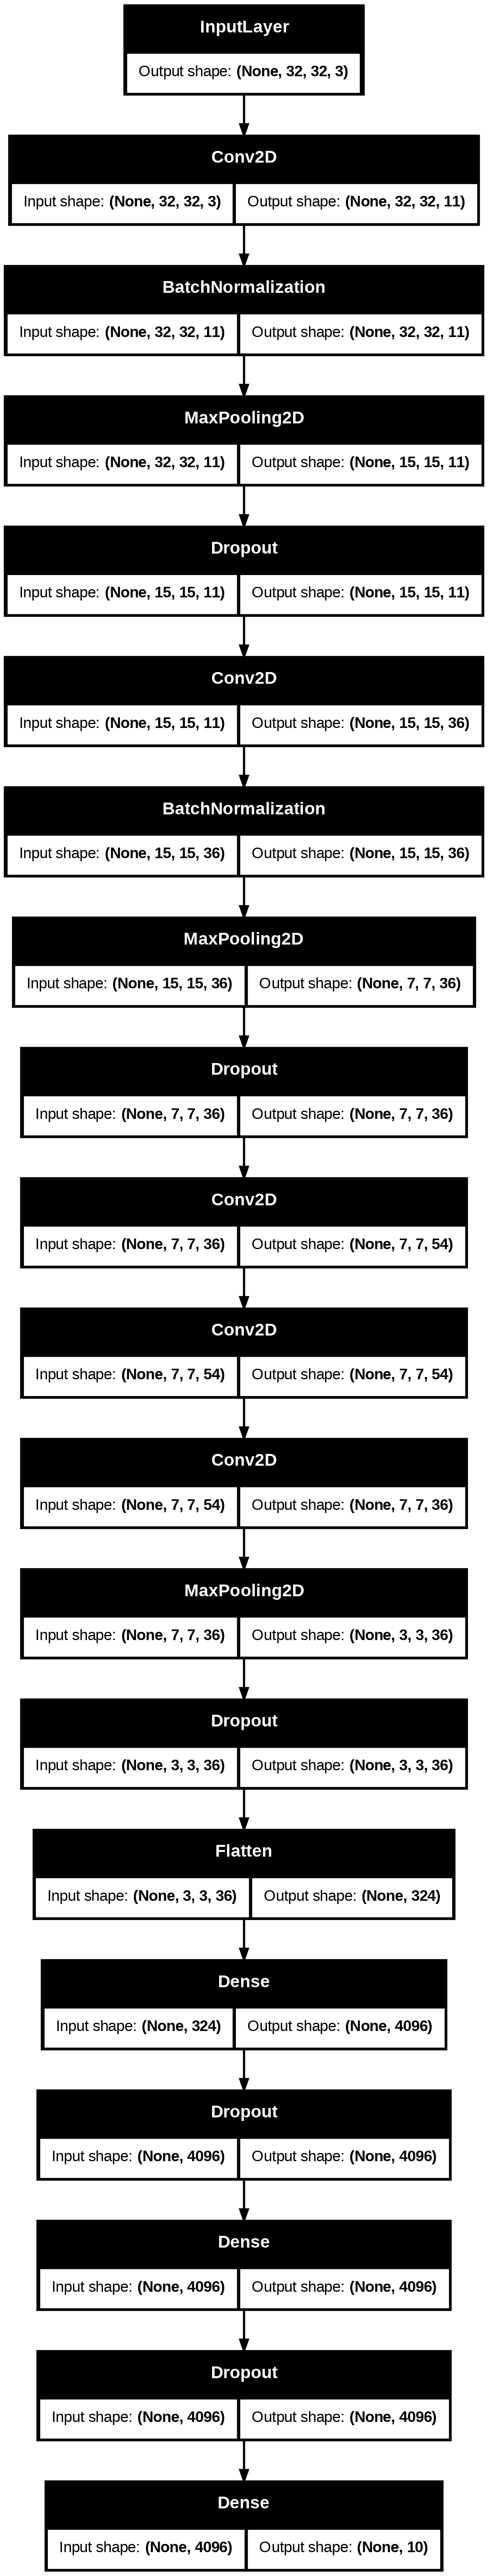

In [32]:
# Define model parameters
input_shape=X_train[0].shape # CIFAR-10 image size = (32, 32, 3)
num_classes = 10           # Number of classes for CIFAR-10

# Build the model using the Functional API
alexnet_scaled_model = AlexNetScaled(input_shape=input_shape, num_classes=num_classes)

# Compile the model
alexnet_scaled_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Summary of the model
alexnet_scaled_model.summary()
keras.utils.plot_model(alexnet_scaled_model, show_shapes=True)

In [33]:
'''
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
x_train = tf.image.resize(x_train, (32, 32)) / 255.0  # Normalize to [0, 1]
x_test = tf.image.resize(x_test, (32, 32)) / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
'''
# Compile the model
alexnet_scaled_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Train the model
alexnet_scaled_model.fit(x_train_norm, y_train_cat, epochs=20, batch_size=64, validation_data=(x_val_norm, y_val_cat))

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2238 - loss: 2.1881 - val_accuracy: 0.0991 - val_loss: 2.6204
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3175 - loss: 1.8563 - val_accuracy: 0.1028 - val_loss: 2.4953
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3399 - loss: 1.8104 - val_accuracy: 0.0997 - val_loss: 3.2394
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3569 - loss: 1.7556 - val_accuracy: 0.0991 - val_loss: 2.5842
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3688 - loss: 1.7486 - val_accuracy: 0.1028 - val_loss: 3.3959
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3718 - loss: 1.7249 - val_accuracy: 0.0991 - val_loss: 3.5442
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3781 - loss: 1.7019 - val_accuracy: 0.1028 - val_loss: 3.2586
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3854 - loss: 1.6911 - val_accuracy: 

In [64]:
'''
K.clear_session()

inputs = keras.Input(shape=(32, 32, 3), name='inputCIFAR10')

# 1st convolutional layer
x=layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding='valid', name='Conv1')(inputs)
x=layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool1')(x)
x=layers.Dropout(0.5)(x)

# Dense Layer
flat = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(flat)
x = layers.Dropout(0.4)(x)

x=layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='CIFAR10_AlexNet_by_Sam')
model.summary()
keras.utils.plot_model(model, show_shapes=True)
'''

"\nK.clear_session()\n\ninputs = keras.Input(shape=(32, 32, 3), name='inputCIFAR10')\n\n# 1st convolutional layer\nx=layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding='valid', name='Conv1')(inputs)\nx=layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool1')(x)\nx=layers.Dropout(0.5)(x)\n\n# Dense Layer\nflat = layers.Flatten()(x)\nx = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(flat)\nx = layers.Dropout(0.4)(x)\n\nx=layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)\nx = layers.Dropout(0.4)(x)\n\noutputs = layers.Dense(10, activation='softmax')(x)\n\nmodel = keras.Model(inputs=inputs, outputs=outputs, name='CIFAR10_AlexNet_by_Sam')\nmodel.summary()\nkeras.utils.plot_model(model, show_shapes=True)\n"